In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import zip_longest
import os
import glob
import ast

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("All measurements V2, cleaned/all_measurements_summery_30,000_cleaned.csv")

In [3]:
heads = [50, 100, 150, 200, 250, 300, 350, 400]
    
dfs = {"full": df}
for h in heads:
    df_h = df.groupby('run_index', group_keys=False).head(h).groupby('run_index', as_index=False).mean(numeric_only=True)
    dfs[f"h{h}"] = df_h

In [4]:
# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge Regression": Ridge(alpha=1.0),
#     "Lasso Regression": Lasso(alpha=0.01),
#     "Decision Tree": DecisionTreeRegressor(random_state=42),
#     "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
# }

# rows = []
# for df_name, d in dfs.items():
#     X = d.drop(columns=["expected_weight", "run_index"])
#     y = d["expected_weight"]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.25, random_state=42
#     )

#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     for name, model in models.items():
#         model.fit(X_train_scaled, y_train)
#         y_pred = model.predict(X_test_scaled)
#         mae = mean_absolute_error(y_test, y_pred)
#         r2 = r2_score(y_test, y_pred)
#         rows.append((df_name, name, mae, r2))

# results_df = pd.DataFrame(rows, columns=["DataFrame", "Model", "MAE", "R2"])
# print(results_df.sort_values(by=["DataFrame", "MAE"]))

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
}

rows = []
for df_name, d in dfs.items():
    if df_name == "full":
        continue
    display_name = f"df_{df_name[1:]}"  # e.g. h50 → df_50
    print(f"\n▶ Processing dataframe: {display_name} ({len(d)} rows)")
    
    X = d.drop(columns=["expected_weight", "run_index"])
    y = d["expected_weight"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        print(f"   - Training {name}...", end=" ", flush=True)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rows.append((df_name, name, mae, r2))
        print(f"done (MAE={mae:.3f}, R²={r2:.3f})")

results_df = pd.DataFrame(rows, columns=["DataFrame", "Model", "MAE", "R2"])
print("\n✅ All runs completed!\n")
print(results_df.sort_values(by=["DataFrame", "MAE"]))


▶ Processing dataframe: df_50 (30973 rows)
   - Training Linear Regression... done (MAE=0.029, R²=0.929)
   - Training Ridge Regression... done (MAE=0.029, R²=0.929)
   - Training Lasso Regression... done (MAE=0.034, R²=0.914)
   - Training Decision Tree... done (MAE=0.028, R²=0.922)
   - Training Random Forest... done (MAE=0.020, R²=0.959)

▶ Processing dataframe: df_100 (30973 rows)
   - Training Linear Regression... done (MAE=0.029, R²=0.932)
   - Training Ridge Regression... done (MAE=0.029, R²=0.932)
   - Training Lasso Regression... done (MAE=0.033, R²=0.915)
   - Training Decision Tree... done (MAE=0.027, R²=0.932)
   - Training Random Forest... done (MAE=0.019, R²=0.964)

▶ Processing dataframe: df_150 (30973 rows)
   - Training Linear Regression... done (MAE=0.029, R²=0.932)
   - Training Ridge Regression... done (MAE=0.029, R²=0.932)
   - Training Lasso Regression... done (MAE=0.033, R²=0.914)
   - Training Decision Tree... done (MAE=0.025, R²=0.936)
   - Training Random For

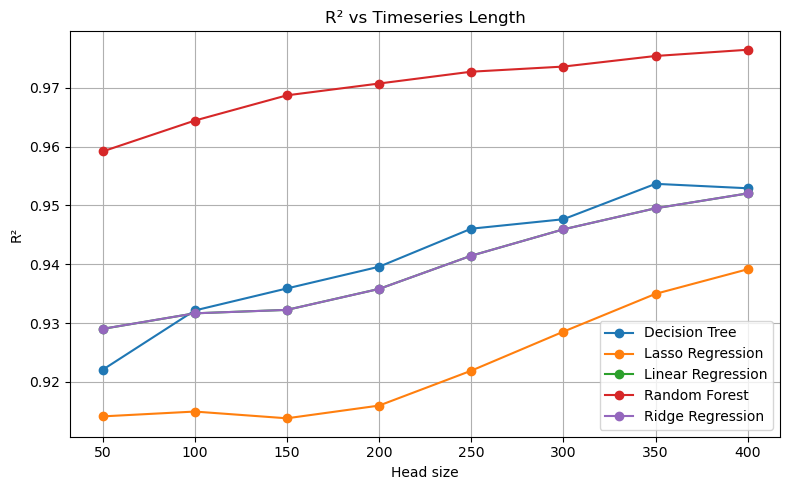

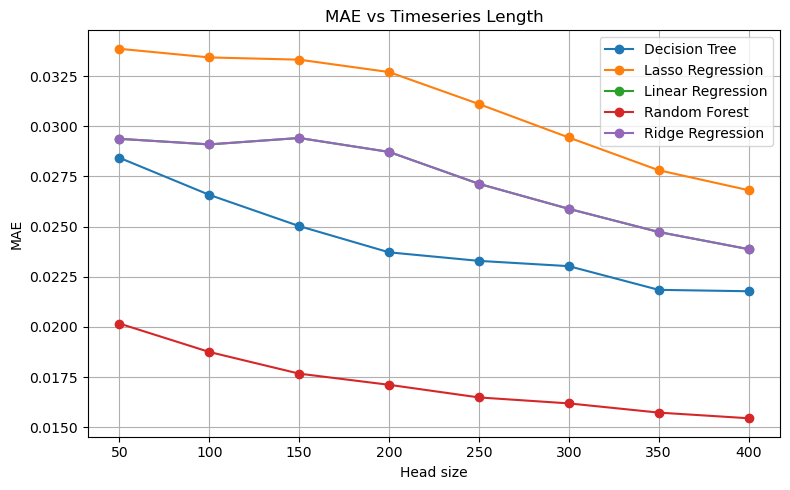

In [7]:
plot_df = results_df[results_df["DataFrame"] != "full"].copy()
plot_df["Head"] = plot_df["DataFrame"].str.extract(r'h(\d+)').astype(int)
plot_df = plot_df.sort_values(["Head", "Model"])

plt.figure(figsize=(8,5))
for model in plot_df["Model"].unique():
    sub = plot_df[plot_df["Model"] == model].sort_values("Head")
    plt.plot(sub["Head"], sub["R2"], marker="o", label=model)
plt.xlabel("Head size")
plt.ylabel("R²")
plt.title("R² vs Timeseries Length")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
for model in plot_df["Model"].unique():
    sub = plot_df[plot_df["Model"] == model].sort_values("Head")
    plt.plot(sub["Head"], sub["MAE"], marker="o", label=model)
plt.xlabel("Head size")
plt.ylabel("MAE")
plt.title("MAE vs Timeseries Length")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()